# 1-Importing Modules


In [1]:
%%capture
!pip install pafy youtube-dl moviepy 

In [2]:
%%capture
!pip install imageio==2.4.1     #There is some package issue due to deprecitation of package in the new package.
!pip install youtube-dl==2020.12.2    #Youtube removed the dislike_count attribute, and that isn't updated in the new package, hence using older version . 

In [3]:
!pip install matplotlib

In [1]:
#Import all the necessary modules as required in the project
#%%capture
import pickle
import os
import cv2
import math 
import pafy
import random 
import numpy as np
import datetime as dt 
import tensorflow as tf 
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Conv2D, MaxPooling2D,TimeDistributed, Dropout,Flatten, Dense  
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical, plot_model 
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#Set the seed constant to get the constant and traceable results
seed_constant = 81
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

#2- Preparing The DataSet 
we will be using the UCF-50 dataset which contains 50 classes of different activites like horse riding,playing basketball, military parade, etc. 
Let's randomly choose 20 classes, and see what they look like.    

NOTE : IF you want to just use the model directly jump to section 4

In [7]:
%%capture 
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y

## 2.1 Visualizing The Data 

Visualizing the data is an important aspect of any ML/DL project.The data used in this project have been taken from UCF50 dataset(https://www.crcv.ucf.edu/data/UCF50.php).The dataset consists of 50 action activities with each action further splitted into 25 groups . Each group further contains more than 4 videos. So roughly we have around 133 videos per action activity. 

We Randomly select 20 videos and display their first video frame to get a gist of the videos and to know our dataset better. 

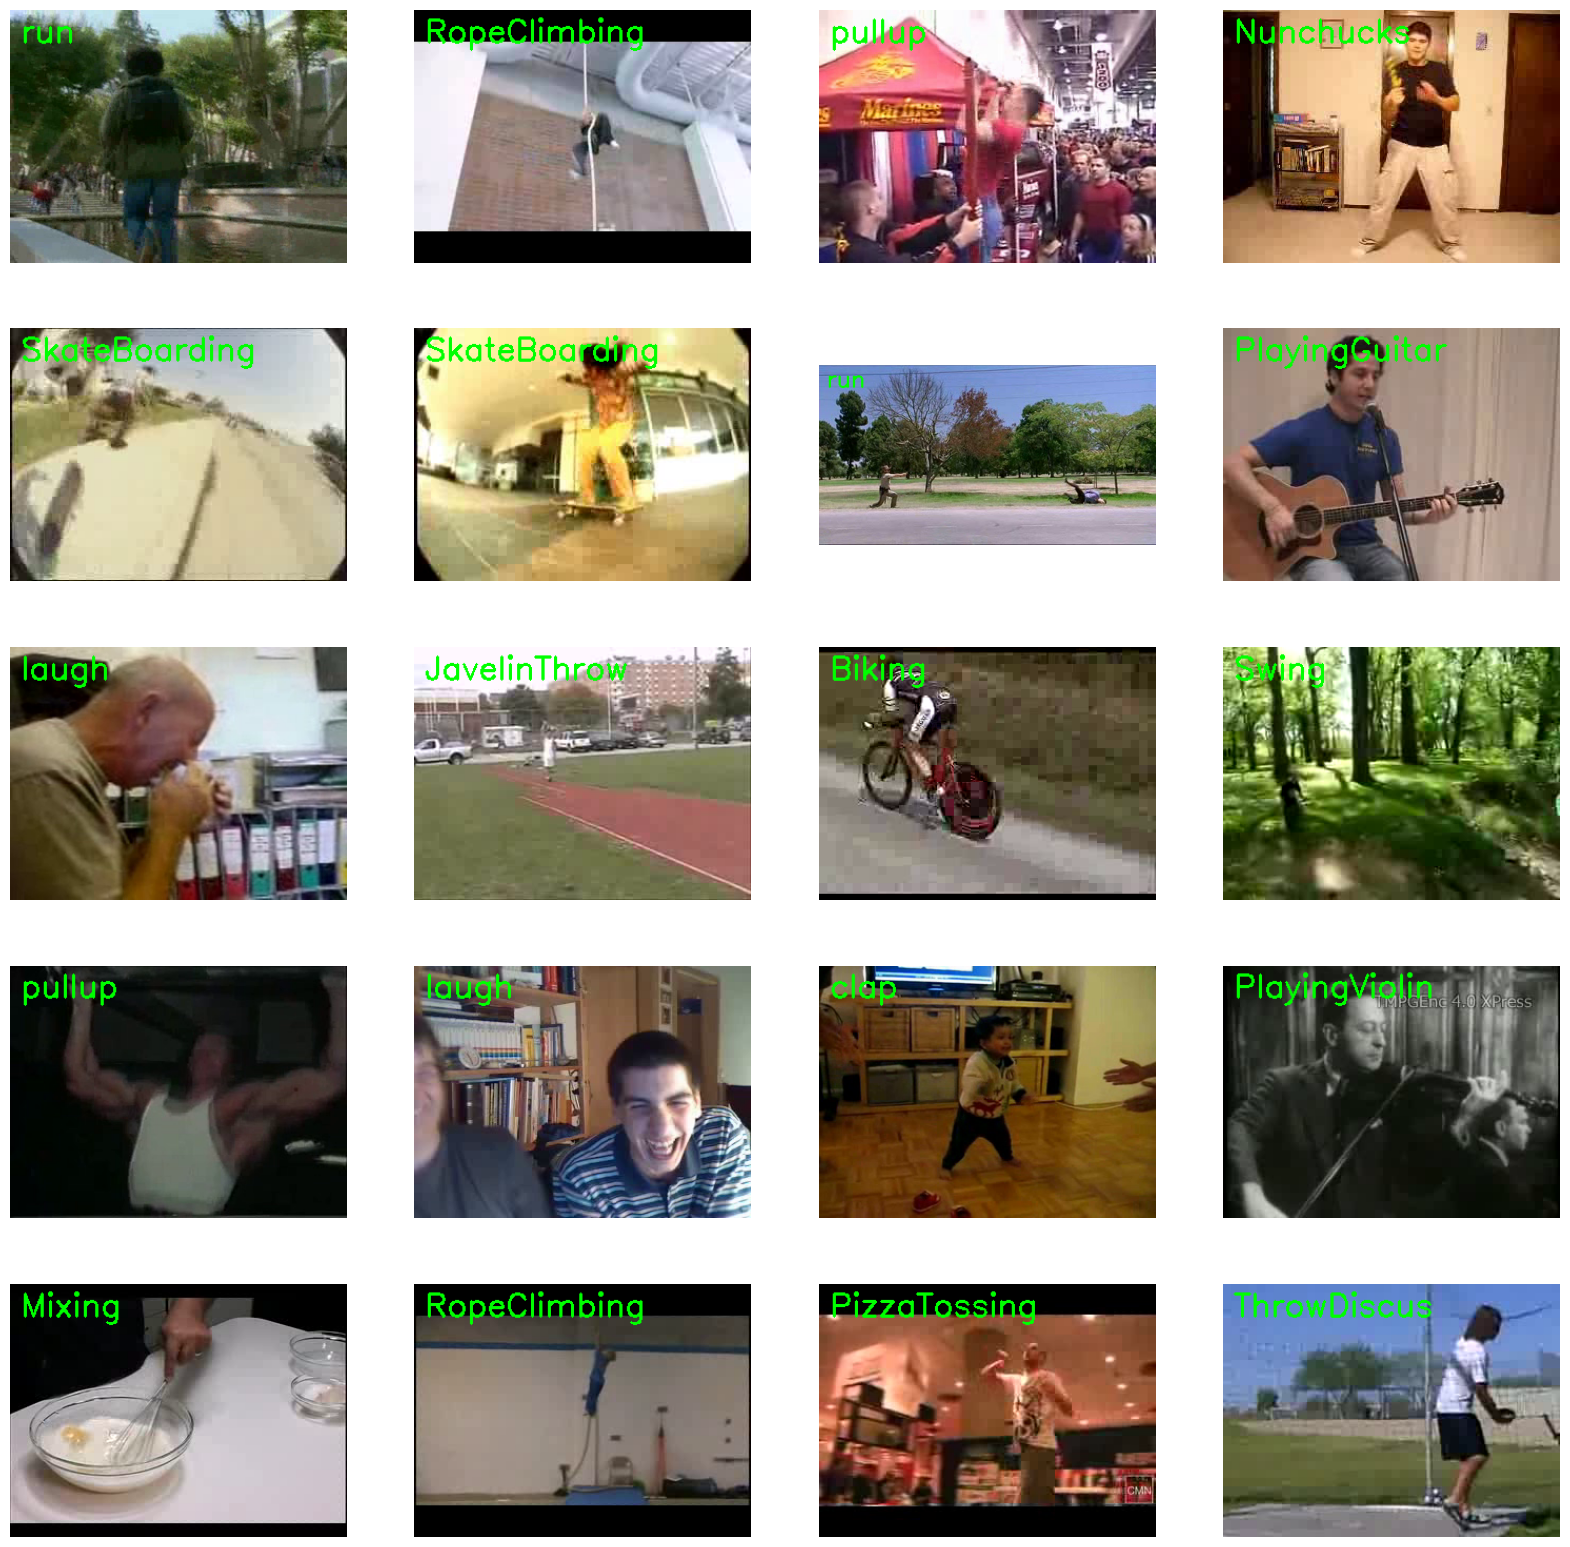

In [3]:
#plot the first video frame of random 20 videos. 

plt.figure(figsize = (20, 20))

all_activities_names = os.listdir('UCF50')
random_choosen_activities = np.random.choice(all_activities_names, 20)
for counter, random_activity in enumerate(random_choosen_activities, 1):
    random_activity_videos = os.listdir(f"UCF50/{random_activity}")
    choosen_random_video = random.choice(random_activity_videos)
    video_reader = cv2.VideoCapture(f'UCF50/{random_activity}/{choosen_random_video}')

     #Capture the initial frame of video. 
    success, bgr_frame = video_reader.read()       
    video_reader.release()
    if not success:
        print("Reading Video Failed\n")
        break
    
    #As cv2 reads in the bgr format, so to plot in matplotlib we need to convert it to rgb colour space. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, random_activity, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    #Add the rgb_frame into the subplot.
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

##2.2 Pre-processing the DATA 

Our original videos are of quite high resolution(240 x 320), which add to the unneccesary computation in the CNN network , hence we reduce them to lower dimensions({VIDEO_IMAGE_HEIGTH} x {VIDEO_IMAGE_WIDTH}). 

SEQUENCE_LENGTH:
We fix the no of sequences that we would be taking into account from each video. Our each video consists approximately of 250 frames, and to process all the video frames very high computation would be required. So , we evenly split the video into {SEQUENCE_LENGTH} frames and use those frames to train our model onto that video . 

CLASSES_LIST:
It would contain list of all the classes that we want our model to train on and can be altered to user's wish.

In [4]:
#Defining Parameters for the pre-processing
VIDEO_IMAGE_HEIGHT, VIDEO_IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 60
DATASET_DIR = 'UCF50'       #Our Dataset directory
CLASSES_LIST = ["PlayingPiano", "Basketball", "walk", "shoot_gun", "run","Rowing","ride_bike","ride_horse", "clap", "Drumming"]

In [5]:
def resize_normalize_video(video_path):
    """
    This splits the video pointed by video_path evenly into SEQUENCE_LENGTH frames, 
    resize those frames to the desired height and width ,and normalize it(color space).  
    Args : 
        video_path : Path to the video whose frames needs to be splitted
    Returns : 
        frames: SEQUENCE_LENGTH frames of the video which are evenly spreaded  
    """
    frames = []

    video_reader = cv2.VideoCapture(video_path)
    total_video_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))    #Total No. of Video frames in video 
    skip_window = max(int(total_video_frames / SEQUENCE_LENGTH), 1)     #Sample the video after regular skipping the window_size. 

    for sequence_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, (sequence_counter*skip_window))
        success, frame = video_reader.read()

        if not success : 
            video_title = os.path.basename(video_path)
            print(f"Video Reading Failed for file at {video_title}")
            break

        resized_frame = cv2.resize(frame,(VIDEO_IMAGE_HEIGHT, VIDEO_IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames.append(normalized_frame)
  
    video_reader.release()

    return frames

In [6]:
def prepare_dataset():
    """
    This function prepares the dataset, so as to make ready for machine learning . 

    Returns : 
        features : Processed Video frames for all the video
        labels : One_hot_encoded vector denoting the target class in CLASSES_LIST. 
    
    """
    features = []
    labels = []

    for counter, activity_name in enumerate(CLASSES_LIST):
        prev = len(features)
        activity_all_videos = os.listdir(os.path.join(DATASET_DIR, activity_name))
        for activity_video in activity_all_videos:
            video_path = os.path.join(DATASET_DIR, activity_name, activity_video)
            video_frame = resize_normalize_video(video_path)
            if len(video_frame) == SEQUENCE_LENGTH:
                features.append(video_frame)
                labels.append(counter)
        curr = len(features)
        print(f'Added {curr-prev} examples for {activity_name}.')
    #Convert all python list into numpy arrays   
    features = np.array(features)
    labels = np.array(labels)
    labels = to_categorical(labels)

    return features, labels

## 2.3 Creating And Splitting The Dataset  

Use prepare_dataset function to prepare the dataset . Split the dataset into train and test set using the sklearn module. 

X_train = features_train = frames of the video evenly splitted across the length

Y_train = labels_train = One_hot_encoded labels denoting activity class

In [7]:
#Obtain the data.
features, labels = prepare_dataset()

Added 105 examples for PlayingPiano.
Video Reading Failed for file at v_Basketball_g02_c01.avi
Video Reading Failed for file at v_Basketball_g02_c02.avi
Added 135 examples for Basketball.
Video Reading Failed for file at 20060723sfjffcomeback_walk_u_cm_np1_ri_med_2.avi
Video Reading Failed for file at 20060723sfjffcookies_walk_u_nm_np1_ba_med_1.avi
Video Reading Failed for file at 20060723sfjffjewcy_walk_f_cm_np1_ba_med_2.avi
Video Reading Failed for file at 20060723sfjffjewgotmail_walk_f_cm_np2_ba_med_2.avi
Video Reading Failed for file at 20060723sfjffprofessionalhelp_walk_u_nm_np2_le_med_0.avi
Video Reading Failed for file at 20060723sfjffschmoozer_walk_f_cm_np2_ri_med_0.avi
Video Reading Failed for file at 20060723sfjffsomelikeitwarmed_walk_f_nm_np1_ba_med_4.avi
Video Reading Failed for file at 20070723_sfjff_waitingforrescue_walk_f_nm_np1_ba_med_1.avi
Video Reading Failed for file at 50_FIRST_DATES_walk_f_cm_np1_fr_med_26.avi
Video Reading Failed for file at 50_FIRST_DATES_walk_f_

In [8]:
#Split the data into train and test sets . 
features_train, features_test, labels_train , labels_test = train_test_split(features, labels, test_size = 0.2, shuffle =True, random_state = seed_constant)

#3 - Constructiong and Training Model

We create the LRCN model . One of the other approach would be to train CNN model separately and LSTM model separately, but in this project we would train both the models in single model only. 

LRCN stands for Long-term Recurrent Convolutional Network , and it combines CNN + LSTM into a single model. 
CNN extracts spatial feature from the frames, which are then fed into an LSTM model at each time step to extract out the temporal information. So model is able to learn both spatial and temporal features effectively. 

In [9]:
def make_LRCN_model():
    '''
    This function will construct the requied LRCN model.
    Returns:
        model: Created LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    #TimeDistributed layer has been used as dealing with the sequential data,
    #and we want to feed our Conv2D layer to all the the time steps .  
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, VIDEO_IMAGE_HEIGHT, VIDEO_IMAGE_WIDTH, 3)))
    
    #MaxPoooling has been used to reduce the size of the input slowly slowly
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))

    #LSTMs always need input as 3D data, and that taken care by our above CNN model                                   
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    return model

## 3.1 Construction of Model




In [10]:
#Initialize the convlstm model . 
lrcn_model = make_LRCN_model()
print("LRCN_model created successfully")

LRCN_model created successfully


In [11]:
#Show how our model looks like. 
plot_model(lrcn_model, to_file = 'lrcn_model_structure_plot.png', show_shapes = True, show_layer_names= True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## 3.2 Training The Model
To train the model we are categorical_crossentropy loss function as our labels are one-hot encoded. We use earlyStopping callback to stop the training if there is no significant change in val-accuracy for the 15 epochs. 

In [12]:
#Train the model. Use EarlyStopping to check for overfitting. 

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
lrcn_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
lrcn_model_training_history = lrcn_model.fit(x = features_train, y = labels_train, epochs = 70,batch_size = 2,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
469/469 [==============================] - 63s 127ms/step - loss: 2.1451 - accuracy: 0.2932 - val_loss: 2.1677 - val_accuracy: 0.2681
Epoch 2/70
469/469 [==============================] - 56s 119ms/step - loss: 2.0111 - accuracy: 0.3156 - val_loss: 2.1064 - val_accuracy: 0.2851
Epoch 3/70
469/469 [==============================] - 53s 112ms/step - loss: 1.9457 - accuracy: 0.3412 - val_loss: 1.9862 - val_accuracy: 0.2894
Epoch 4/70
469/469 [==============================] - 52s 111ms/step - loss: 1.8862 - accuracy: 0.3635 - val_loss: 1.7586 - val_accuracy: 0.4085
Epoch 5/70
469/469 [==============================] - 53s 113ms/step - loss: 1.7483 - accuracy: 0.4019 - val_loss: 1.7145 - val_accuracy: 0.3957
Epoch 6/70
469/469 [==============================] - 56s 120ms/step - loss: 1.6102 - accuracy: 0.4542 - val_loss: 1.5672 - val_accuracy: 0.4596
Epoch 7/70
469/469 [==============================] - 97s 206ms/step - loss: 1.5550 - accuracy: 0.4829 - val_loss: 1.5492 - val_ac

## 3.3 Evaluating The Model

In [12]:
model_evaluation_history = lrcn_model.evaluate(features_test, labels_test)

NameError: name 'features_test' is not defined

## 3.4 Ploting Metrics

In [14]:
def plot_metric(training_history, metric1, metric2, plot_name):
    """
    This function plots the metric1 and metric2 in the same graph, with epochs on the x-axis.
    Args : 
        training_history : tensorflow history object (of model)
        metric1 : First metric to be plotted
        metric2 : Second metric to be plotted
        plot name : The name to be given to the plot

    Returns : 
        None , 
        Plots the Required Graph. 
    """
    metric1_val = training_history.history[metric1]
    metric2_val = training_history.history[metric2]

    epochs = range(len(metric1_val))

    plt.plot(epochs, metric1_val, 'green', label = metric1)
    plt.plot(epochs, metric2_val, 'red', label = metric2)

    plt.title(str(plot_name))
    plt.legend()
    plt.show()

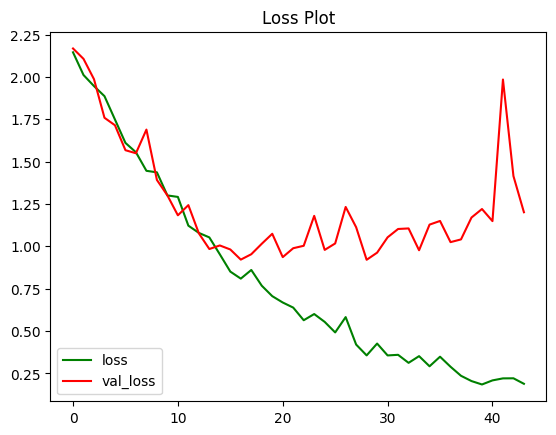

In [15]:
#Plot : loss and val_loss Vs epochs
plot_metric(lrcn_model_training_history, 'loss', 'val_loss', 'Loss Plot')

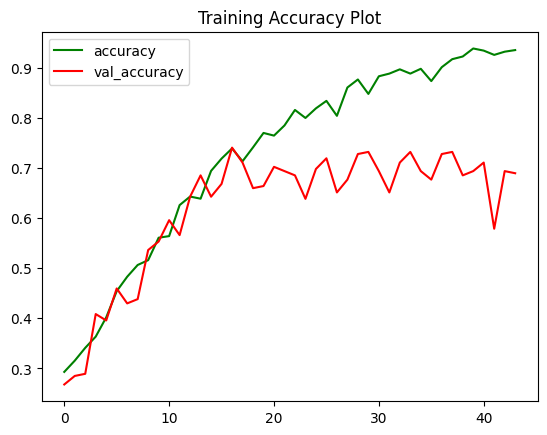

In [16]:
#Plot : accuracy and val_accuracy Vs epochs 
plot_metric(lrcn_model_training_history, 'accuracy', 'val_accuracy', 'Training Accuracy Plot')

## 3.5 Save The Model

In [18]:
# Define path
model_file_name = 'project/autofoley/video_lrcn/lrcns.h5'

# Save
lrcn_model.save(model_file_name)

# 4-Testing The Model on Youtube Videos

In [19]:
lrcn_model = load_model('project/autofoley/video_lrcn/lrcns.h5')

## 4.1Download Video

We use the pafy youtube-dl module to download the video from youtube. If want to use youtube to test function use this function else load video from drive. As distribution of data become different for youtube video case from the training data distribution, so it mayn't perform very good. 

In [6]:
def download_youtube_videos(url, output_dir):
    """
    This function downloads the youtube video from {url} and save it to output_dir
    Args : 
        url : url of the youtube video that needs to be downloaded
        output_dir = output_directory to save the downloaded video to. 
    Returns:
        title : title of the downloaded youtube video. 
    """
    video = pafy.new(url)
    title = video.title
    video_best = video.getbest()
    output_file_path = f'{output_dir}/{title}.mp4'

    video_best.download(filepath = output_file_path, quiet = True)
    return title

In [20]:
#Download the Youtube Video

test_videos_dir = 'test_videos'
os.makedirs(test_videos_dir, exist_ok = True)

#Comment below line if not making prediction on saved video . 
input_video_file_path = 'FoleyGen/project/foleygen/video_lrcn/v_PlayingPiano_g06_c04.mp4'

#Uncomment below lines for frame for youtube video prediction

#video_title = download_youtube_videos('https://www.youtube.com/watch?v=DCiM2uPIt30', test_videos_dir)

#input_video_file_path = f'{test_videos_dir}/{video_title}.mp4'




## 4.2 Annotate Prediction To The Video-Frame by Frame

We use openCV for reading and writing the video file . We read the video frame by frame and store all those frames in a queue object after resizing and normalizing them to conform with the training data. As soon as our queue size becomes same as the SEQUENCE_LENGTH, we use our model to make predictions on those saved frames, and that is annotated on top of the video and written to the output path. 
Queue has been used for its FIFO policy, we keep removing the frames that came first to add the new frames so that effective size of our queue remains same as {SEQUENCE_LENGHT}

In [15]:
def predict_on_video(model, video_file_path, output_file_path):
    """
    This function reads the video and save the prediction annotated video . 
    Args: 
        model : model to be used for the prediction 
        video_file_path : path to the video on which prediction needs to be done. 
        output_file_path: path where to save the annotated video. 
    Returns : 
        None 
    """
    #Intializing video_reader and video_writer objects. 
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(*'mp4v'), video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    
    # As soon our queue will become equal to the SEQUENCE_LENGTH, we make prediction . 
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
    predicted_activity_name = '---'

    while video_reader.isOpened():
        success, frame = video_reader.read()

        if not success : 
            print("Video Reading Failed\n")
            break
        
        #Resize, normalize, and append the frames to the queue. 
        resized_frame = cv2.resize(frame, (VIDEO_IMAGE_HEIGHT, VIDEO_IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames_queue.append(normalized_frame)

        #If queue size becomes equal to SEQUENCE_LENGTH, make prediction using the "model". 
        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels = model.predict(np.expand_dims(frames_queue, axis = 0))[0]
            predicted_activity_index = np.argmax(predicted_labels)
            predicted_activity_name = CLASSES_LIST[predicted_activity_index]

        #Append the prediction on the frame . 
        cv2.putText(frame, predicted_activity_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)
    
    #Release the resources 
    video_reader.release()
    video_writer.release()


In [22]:

import ipywidgets as widgets
# Construct the output video path.
output_video_file_path = f'Output_predicted_video1.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(lrcn_model, input_video_file_path, output_video_file_path)

# Display the output video.




def display_video_widget(video_path):
    return widgets.Video.from_file(video_path, width=640, height=480, controls=True)

# Display the output video.
display_video_widget(output_video_file_path)

Video(value=b'', height='480', width='640')

## 4.3 Make Single Prediction on the Entire Video  
We split the test_video evenly into {SEQUENCE_LENGTH} frames, and use our saved model to make predictions on those set of frames. 

In [16]:
def predict_single_action(model, video_file_path):
    '''
    This will predict a single action using the model that is being performed in the video. 
    Args:
        model : The model to be used for making predictions . 
        video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    '''

    # Initialize the video_reader. 
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frames_list = []

    # Get the number of frames in the video, and raise Error if not enough frames in the video .
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    if video_frames_count < SEQUENCE_LENGTH:
        print("ERROR : Not Enough Frames to make Predictions")
        return 

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):

        #Set the video_reader to the desired frame. 
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 

        # Check if frame is not read properly then break the loop.
        if not success:
            print("Video Reading Failed")
            break

        # Resize, normalize and append
        resized_frame = cv2.resize(frame, (VIDEO_IMAGE_HEIGHT, VIDEO_IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    #Make prediction 
    predicted_labels_probabilities = model.predict(np.expand_dims(frames_list, axis = 0))[0]
    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Print Result
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label] * 100}')
        
    # Release Resources 
    video_reader.release()

In [22]:
# Download the youtube video.
#video_title = download_youtube_videos('https://www.youtube.com/watch?v=yJKZ3JDLM-w', test_videos_dir)
input_video_file_path = f'uploads/running.mp4'



# Perform Single Prediction on the Test Video.
predict_single_action(lrcn_model, input_video_file_path)

1/1 [==============================] - 0s 40ms/step
Action Predicted: ride_bike
Confidence: 82.90076851844788


In [ ]:
# # Display the input video.
# VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

## Save helpers for future use. 

In [21]:
lrcn_helpers = [SEQUENCE_LENGTH, VIDEO_IMAGE_HEIGHT, VIDEO_IMAGE_WIDTH, CLASSES_LIST]

with open('project/autofoley/video_lrcn/lrcn_helpers', 'wb') as filepath:
    pickle.dump(lrcn_helpers, filepath)